In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import investpy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv('ethereum.csv')
print(df)

           Date     Open     High      Low    Close    Volume Currency
0    2020-06-01  0.23180  0.24981  0.23085  0.24797  11970598      USD
1    2020-06-02  0.24801  0.25321  0.22795  0.23794  12686011      USD
2    2020-06-03  0.23790  0.24476  0.23384  0.24452   8151002      USD
3    2020-06-04  0.24453  0.24641  0.23668  0.24337   8749785      USD
4    2020-06-05  0.24337  0.24750  0.23970  0.24023   7754761      USD
..          ...      ...      ...      ...      ...       ...      ...
726  2022-05-28  1.72467  1.80779  1.72288  1.79268    658227      USD
727  2022-05-29  1.79225  1.82481  1.76472  1.81356    554579      USD
728  2022-05-30  1.81356  2.00995  1.80433  1.99846   1036963      USD
729  2022-05-31  1.99846  2.01502  1.92893  1.94179    933239      USD
730  2022-06-01  1.94181  1.97122  1.77085  1.81807   1293546      USD

[731 rows x 7 columns]


In [3]:
# Process data
df['H-L'] = df['High'] - df['Low']
df['O-C'] = df['Open'] - df['Close']
ma_1 = 7
ma_2 = 14
ma_3 = 21
df[f'SMA_{ma_1}'] = df['Open'].rolling(window=ma_1).mean()
df[f'SMA_{ma_2}'] = df['Open'].rolling(window=ma_2).mean()
df[f'SMA_{ma_3}'] = df['Open'].rolling(window=ma_3).mean()

df[f'SD_{ma_1}'] = df['Open'].rolling(window=ma_1).std()
df[f'SD_{ma_3}'] = df['Open'].rolling(window=ma_3).std()
df.dropna(inplace=True)

df.to_csv("ethereum_processed_8_2.csv")
df

,Date,Open,High,Low,Close,Volume,Currency,H-L,O-C,SMA_7,SMA_14,SMA_21,SD_7,SD_21
20,2020-06-21,0.22887,0.23118,0.22738,0.22813,4102533,USD,0.00380,0.00074,0.231636,0.236451,0.238009,0.002366,0.006486
21,2020-06-22,0.22811,0.24639,0.22769,0.24325,7929329,USD,0.01870,-0.01514,0.231081,0.235276,0.237833,0.002700,0.006709
22,2020-06-23,0.24324,0.24477,0.24094,0.24320,5163349,USD,0.00383,0.00004,0.232841,0.235065,0.237606,0.005321,0.006422
23,2020-06-24,0.24320,0.24923,0.23156,0.23475,9127950,USD,0.01767,0.00845,0.233960,0.235021,0.237859,0.006608,0.006537
24,2020-06-25,0.23475,0.23529,0.22799,0.23256,6475813,USD,0.00730,0.00219,0.234089,0.234089,0.237393,0.006615,0.006385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2022-05-28,1.72467,1.80779,1.72288,1.79268,658227,USD,0.08491,-0.06801,1.918781,1.974346,2.067673,0.114964,0.215226
727,2022-05-29,1.79225,1.82481,1.76472,1.81356,554579,USD,0.06009,-0.02131,1.892657,1.955484,2.027493,0.120664,0.179634
728,2022-05-30,1.81356,2.00995,1.80433,1.99846,1036963,USD,0.20562,-0.18490,1.859853,1.931748,1.993854,0.102813,0.145744
729,2022-05-31,1.99846,2.01502,1.92893,1.94179,933239,USD,0.08609,0.05667,1.863489,1.929995,1.982843,0.107810,0.135404


In [4]:
pre_day = 30
scala_x = MinMaxScaler(feature_range=(0,1))
scala_y = MinMaxScaler(feature_range=(0,1))
cols_x = ['H-L', 'O-C', f'SMA_{ma_1}', f'SMA_{ma_2}', f'SMA_{ma_3}', f'SD_{ma_1}', f'SD_{ma_3}']
cols_y = ['Open']
scaled_data_x = scala_x.fit_transform(df[cols_x].values.reshape(-1, len(cols_x)))
scaled_data_y = scala_y.fit_transform(df[cols_y].values.reshape(-1, len(cols_y)))

x_total = []
y_total = []

for i in range(pre_day, len(df)):
    x_total.append(scaled_data_x[i-pre_day:i])
    y_total.append(scaled_data_y[i])

test_size = (int)(len(scaled_data_y) * 0.2)
print(test_size)

x_train = np.array(x_total[:len(x_total)-test_size])
x_test = np.array(x_total[len(x_total)-test_size:])
y_train = np.array(y_total[:len(y_total)-test_size])
y_test = np.array(y_total[len(y_total)-test_size:])



print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

142
(539, 30, 7) (539, 1) (142, 30, 7) (142, 1)


In [5]:
# Build model
model = Sequential()

model.add(LSTM(units=60, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=len(cols_y)))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=120, steps_per_epoch=40, use_multiprocessing=True)
model.save("ethereum_lstm_8_2.h5")

Epoch 1/120
40/40 [==============================] - 19s 42ms/step - loss: 0.0310
Epoch 2/120
40/40 [==============================] - 2s 46ms/step - loss: 0.0110
Epoch 3/120
40/40 [==============================] - 2s 40ms/step - loss: 0.0112
Epoch 4/120
40/40 [==============================] - 2s 40ms/step - loss: 0.0099
Epoch 5/120
40/40 [==============================] - 2s 42ms/step - loss: 0.0086
Epoch 6/120
40/40 [==============================] - 2s 42ms/step - loss: 0.0107
Epoch 7/120
40/40 [==============================] - 2s 43ms/step - loss: 0.0101
Epoch 8/120
40/40 [==============================] - 2s 42ms/step - loss: 0.0074
Epoch 9/120
40/40 [==============================] - 2s 42ms/step - loss: 0.0086
Epoch 10/120
40/40 [==============================] - 2s 41ms/step - loss: 0.0084
Epoch 11/120
40/40 [==============================] - 2s 42ms/step - loss: 0.0069
Epoch 12/120
40/40 [==============================] - 2s 42ms/step - loss: 0.0067
Epoch 13/120
40/40 [====

In [6]:
# Testing
predict_price = model.predict(x_test)
predict_price = scala_y.inverse_transform(predict_price)

5/5 [==============================] - 3s 16ms/step


(142, 1)


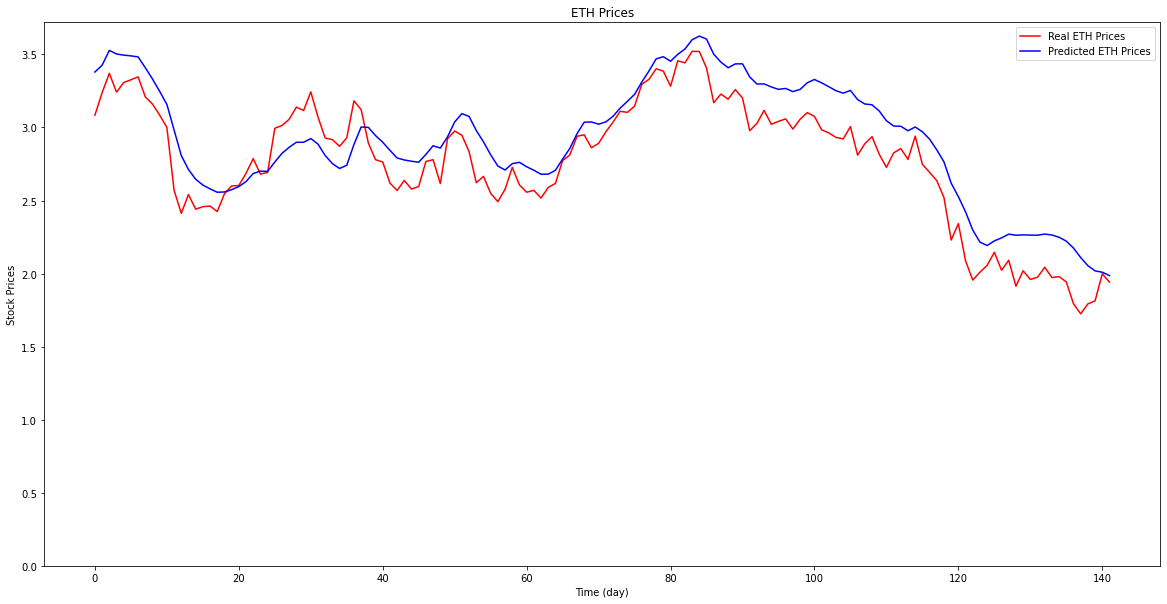

In [7]:
# Ploting the stat
real_price = df[len(df)-test_size:]['Open'].values.reshape(-1,1)
real_price = np.array(real_price)
print(real_price.shape)
real_price = real_price.reshape(real_price.shape[0], 1)

plt.figure(figsize=(20,10))
plt.plot(real_price, color="red", label="Real ETH Prices")
plt.plot(predict_price, color="blue", label="Predicted ETH Prices")
plt.title("ETH Prices")
plt.xlabel("Time (day)")
plt.ylabel("Stock Prices")
plt.ylim(bottom=0)
plt.legend()
plt.show()

In [8]:
# Make Prediction
x_predict = df[len(df)-pre_day:][cols_x].values.reshape(-1, len(cols_x))
x_predict = scala_x.transform(x_predict)
x_predict = np.array(x_predict)
x_predict = x_predict.reshape(1, x_predict.shape[0], len(cols_x))

prediction = model.predict(x_predict)
prediction = scala_y.inverse_transform(prediction)
print(prediction)

1/1 [==============================] - 0s 23ms/step
[[1.9392186]]


In [9]:
mae = mean_absolute_error(real_price, predict_price)
mape = mean_absolute_percentage_error(real_price, predict_price)
mse = mean_squared_error(real_price, predict_price)
rmse = np.sqrt(mse)
r2 = r2_score(real_price, predict_price)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.18
MAPE: 7.03%
MSE: 0.04
RMSE: 0.21
R2: 0.76
